In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

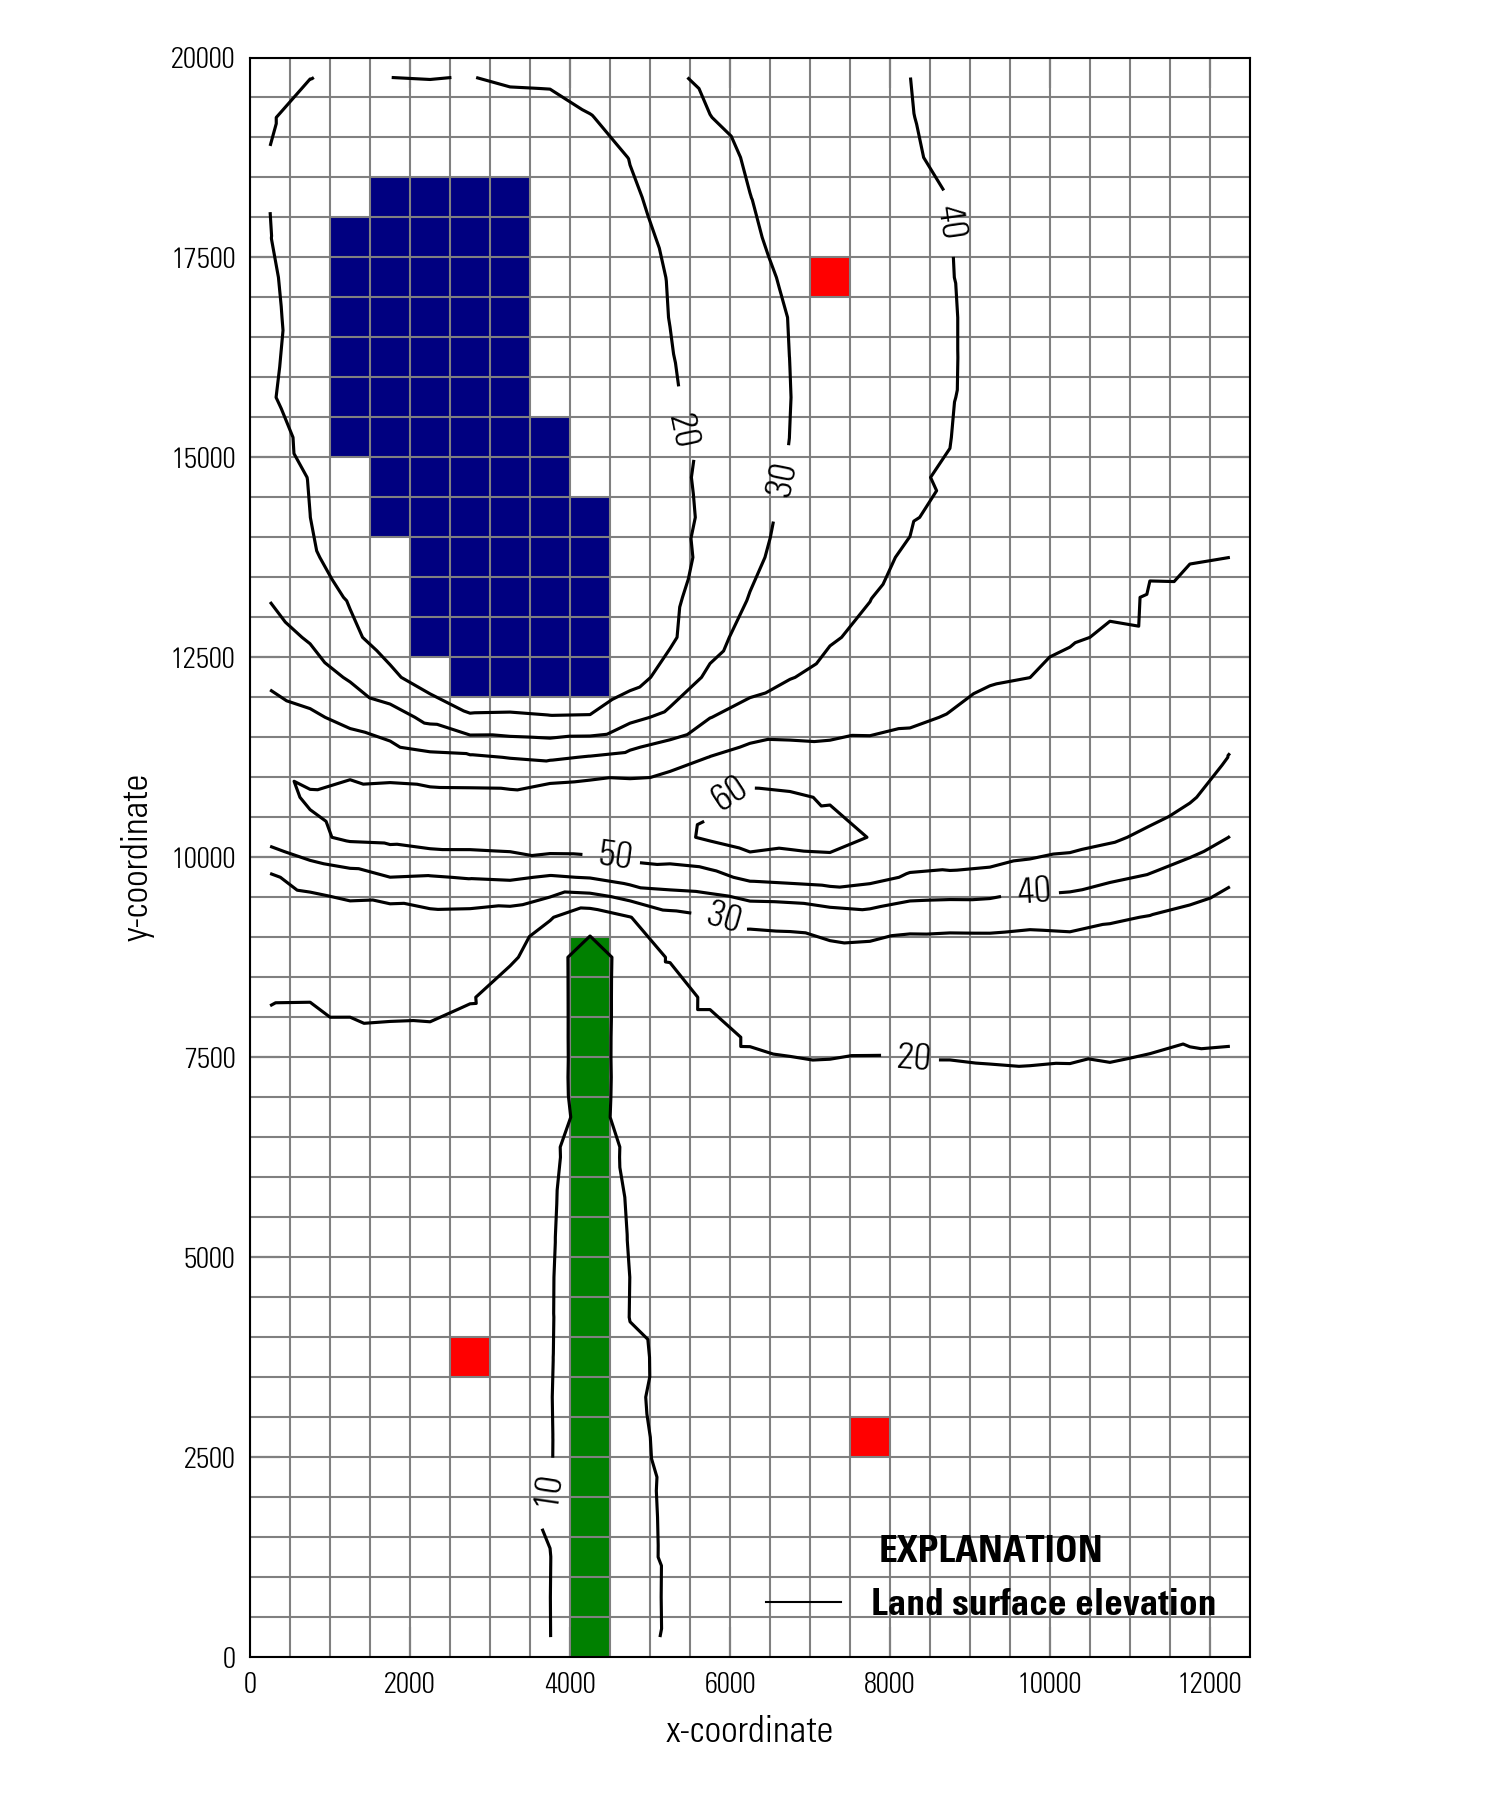

### Adding advanced package to an existing MODFLOW 6 model

A MODFLOW 6 model of the domain shown above has been provided. We will convert this model from the standard formulation model to one that uses the Newton-Raphson formulation. We will also convert the river (RIV) and well (WEL) packages to streamflow routing (SFR) and multi-aquifer well (MAW) packages,

The model domain is discretized into 5 layers, 40 rows, and 25 columns. `delr` and `delc` are defined as constant values of 500. The top of the model is set to 100 and the bottom of the top four layers is set to -5, -50, -51, and -100. The bottom of layer 5 is variable. The model has three steady-state stress periods. The model includes constant heads, representing a lake, recharge, and river cells that are constant for all three stress periods. The pumping rates for the wells vary in all three stress periods.

The model files are in the `../data/mcdonaldvalley/` subdirectory and can be loaded using the `flopy.mf6.MFSimulation.load()` method. Before loading the simulation object you should define the simulation workspace (`sim_ws`) where the model files are located, the simulation name (`name`), and the name and path of the model executable (`exe_name`).  The `sim_ws` should be set to `'../data/mcdonaldvalley'`, `name` should be set to `mv`, and `exe_name` should be set to `bin/mf6`.

In [ ]:
ws = '../data/mcdonaldvalley'
name = 'mv'
exe_name = os.path.abspath('../bin/mf6')
sim = flopy.mf6.MFSimulation.load(sim_name=name, exe_name=exe_name, sim_ws=ws)

#### Change the model workspace and run the model

The model workspace can be changed using `sim.set_sim_path(wsa)`, where `wsa` is set to be `data/ex04a`. Next write the simulation using `sim.write_simulation()` and run the base model using `sim.run_simulation()`.

In [ ]:
wsa = 'data/ex04a'
sim.set_sim_path(wsa)
sim.write_simulation()
sim.run_simulation()

#### Retrieve groundwater model and post-process existing model results

We need to retrive the groundwater model object so that we can add the advanced stress packages and remove the equivalent standard stress packages. The groundwater model object can be retrieved using the `sim.get_model()` method. After retrieving the model, plot the heads for the first stress period and plot the location of the `CHD`, `RIV`, and `WEL` packages.

In [ ]:
gwf = sim.get_model('mv')

In [ ]:
hpth = os.path.join(wsa, name+'.hds')
hobja = flopy.utils.HeadFile(hpth)
heada = hobja.get_data(totim=1.)

In [ ]:
cpth = os.path.join(wsa, name+'.cbc')
cobja = flopy.utils.CellBudgetFile(cpth, precision=hobja.precision)
spda = cobja.get_data(text='DATA-SPDIS')[0]

In [ ]:
mm = flopy.plot.PlotMapView(model=gwf)
v = mm.plot_array(heada)
mm.plot_specific_discharge(spda)
mm.plot_bc('CHD')
mm.plot_bc('RIV')
mm.plot_bc('WEL', plotAll=True)
c = mm.contour_array(heada, linewidths=0.75, colors='white', levels=np.arange(0, 20, 1))
plt.clabel(c, fmt='%2d')
plt.colorbar(v, shrink=0.5);

#### Convert the model to use the Newton-Raphson formulation

The model can be converted to the Newton-Raphson formulation by setting the newtonoptions for the groundwater flow model to a empty string using `gwf.name_file.newtonoptions = ''`. Alternatively, the Newton-Raphson under-relaxation can be turned on by setting the `newtonoptions` to `under_relaxation`.

The iterative model solution (IMS) solver cannot use the preconditioned conjugate gradient solver (`CG`) when the Newton-Raphson formulation is used. The original model uses the `simple` complexity option, which uses the `CG` solver. Print the `sim.ims.complexity` variable to confirm this. The complexity option can be reset using `sim.ims.complexity = 'MODERATE'`, which will change the solver to the biconjugate gradient stabilized solver (`BICGSTAB`).

In [ ]:
gwf.name_file.newtonoptions = ''

In [ ]:
print(sim.ims.complexity)

In [ ]:
sim.ims.complexity = 'MODERATE'

#### Convert the river package to a SFR package

First retrieve the location of the river cells from the river package using `gwf.riv_0.stress_period_data.array[0]`

In [ ]:
riv_data = gwf.riv_0.stress_period_data.array[0]

List the river data

In [ ]:
riv_data

**The process of creating the SFR package data is a little involved so this has been completed for you.** First we will create an empty numpy recarray, using `flopy.mf6.ModflowGwfsfr.packagedata.empty()`, that will be filled with data from the river package.

In [ ]:
pakdata = flopy.mf6.ModflowGwfsfr.packagedata.empty(gwf, maxbound=riv_data.shape[0])

List the SFR pakdata dtype

In [ ]:
pakdata.dtype

Fill the SFR pakdata array

In [ ]:
for idx, (r, s) in enumerate(zip(riv_data, pakdata)):
    rl = 500
    rw = 50
    rt = 1.
    if idx == 0 or idx + 1 == riv_data.shape[0]:
        icon = 1
    else:
        icon = 2
    # update pakdata
    rk = r['cond'] * rt / (rl * rw)
    s['rno'] = idx
    s['cellid'] = r['cellid']
    s['rlen'] = rl
    s['rwid'] = rw
    s['rgrd'] = .1 / rl
    s['rtp'] = r['rbot']
    s['rbth'] = rt
    s['rhk'] = rk
    s['man'] = 0.03
    s['ncon'] = icon
    s['ustrf'] = 1.
    s['ndv'] = 0

Print the filled pakdata array

In [ ]:
pakdata

Next create the connectivity data. The connectivity information includes the reach number, the upstream reach numbers, and the downstream reach numbers. Downstream reaches are defined by a negative reach number. **For expedience the connectivity has been completed for you.**

In [ ]:
iconn = []
for idx, s in enumerate(pakdata):
    iconnr = [idx]
    if idx > 0:
        iconnr.append(idx - 1)
    if idx + 1 < pakdata.shape[0]:
        iconnr.append(-(idx + 1))
    # update iconn
    iconn.append(iconnr)

In [ ]:
iconn

Add the streamflow routing package to the groundwater flow model using the `flopy.mf6.ModflowGwfsfr()` method. Since the length and time units are feet and days a unit conversion factor of `1.486 x 86400` needs to be applied to scale the Mannings roughness coefficients to units consistent with model units. The `flopy.mf6.ModflowGwfsfr()` method will also need the package data (`pakdata`), connection data (`iconn`), and the number of reaches (`pakdata.shape[0]`).

So we can evaluate the simulated reach stages we will save the stage data using `stage_filerecord` and specifying a file name (`fstg`) of `name + '.stage.bin'`.

In [ ]:
fstg = name + '.stage.bin'
unit_conversion = 1.486 * 86400.
sfr = flopy.mf6.ModflowGwfsfr(gwf, stage_filerecord=fstg,
                              unit_conversion=unit_conversion, 
                              print_flows=True, print_stage=True,
                              nreaches=pakdata.shape[0], 
                              packagedata=pakdata, connectiondata=iconn)

Remove the existing river package (`RIV_0`) from the groundwater flow model using the `.remove_package()` method.

In [ ]:
gwf.remove_package('RIV_0')

#### Convert the well package to a MAW package

First retrieve the location of the wells and pumping rates in all 3 stress periods from the well package using `gwf.wel.stress_period_data.array[iper]` where `iper` is the period number.

In [ ]:
gwf.package_names

In [ ]:
gwf.wel.stress_period_data.array[0]

In [ ]:
wel_data = {}
for iper in range(3):
    wel = gwf.wel.stress_period_data.array[iper]
    wel_data[iper] = wel.copy()

In [ ]:
wel_data

**The process of creating the package data for the MAW package is a little involved so this has been completed for you.** First we will create an empty numpy recarray, using `flopy.mf6.ModflowGwfmaw.packagedata.empty()`, that will be filled with data from the well package. There are 3 unique well locations.

In [ ]:
nmaw = 3
pak_data = flopy.mf6.ModflowGwfmaw.packagedata.empty(model=gwf, maxbound=nmaw)

List the MAW package data

In [ ]:
pak_data

Fill the MAW package data. The well radius will be set to 0.25. Because each stress period is steady-state the starting head in the well (`strt`) can be set to any value, we will use a value of 0. `condeqn` will be set to `'THEIM'`. The bottom of the well (`bottom`) will be set to the bottom of the layer in cell location. Define an array (`botm`) using data from the `gwf` model (`gwf.dis.botm.array`). There will be 1 groundwater node (`'ngwfnodes'`) per cell. We will also create a counter (`ncon_maw`) with the number of groundwater connections for when we make the MAW connection data.

In [ ]:
botm = gwf.dis.botm.array
botm.shape

In [ ]:
ncon_maw = 0
for iwel, pd in enumerate(pak_data):
    cellid = wel_data[0]['cellid'][iwel]
    pd['wellno'] = iwel
    pd['radius'] = 0.25
    pd['bottom'] = botm[cellid]
    pd['strt'] = 0
    pd['condeqn'] = 'THEIM'
    pd['ngwfnodes'] = 1
    ncon_maw += 1 

List the MAW package data

In [ ]:
pak_data

**The process of creating the connection data for the MAW package is a little involved so this has been completed for you.** First we will create an empty numpy recarray, using `flopy.mf6.ModflowGwfmaw.connectiondata.empty()`, that will be filled with data from the well package. The connection data recarry will be dimensioned to the number of groundwater connections.

In [ ]:
mawcon_data = flopy.mf6.ModflowGwfmaw.connectiondata.empty(model=gwf, maxbound=ncon_maw)

List the MAW connection data

In [ ]:
mawcon_data

Fill the MAW connection data. `icon` will be set to 0 for each connection. `cellid` will be retrieved from the well package data. `scrn_top` and `scrn_bot` will be set to the top and bottom of the layer in cell location. `hk_skin` and `radius_skin` can be set to any value since the theim equation is being used, set these values to -999.

In [ ]:
for iwel, mc in enumerate(mawcon_data):
    cellid = wel_data[0]['cellid'][iwel]
    mc['wellno'] = iwel
    mc['icon'] = 0
    mc['cellid'] = cellid
    top = botm[cellid[0]-1, cellid[1], cellid[2]]
    bot = botm[cellid]
    mc['scrn_top'] = top
    mc['scrn_bot'] = bot
    mc['hk_skin'] = -999
    mc['radius_skin'] = -999

List the MAW connection data

In [ ]:
mawcon_data

Create the period data for the MAW package from the wel pumping data. **The process of creating the MAW package period data is a little involved so this has been completed for you.** All of the pumping rates for the first stress period are zero, so period data only needs to be defined for stress period 2 and 3. This ha

In [ ]:
period_data = {}
for iper in range(1, 3):
    wd = wel_data[iper]
    pd = []
    for iwel, v in enumerate(wd):
        pd.append([iwel, 'RATE', v['q']])
    period_data[iper] = pd

List the period data

In [ ]:
period_data

Add the MAW package to the groundwater flow model using the `flopy.mf6.ModflowGwfmaw()` method. The `flopy.mf6.ModflowGwfmaw()` method will also need the package data (`pak_data`), connection data (`mawcon_data`), and the number of maw wells (`nmaw`)

In [ ]:
maw = flopy.mf6.ModflowGwfmaw(gwf, print_head=True,
                              nmawwells=nmaw,  
                              packagedata=pak_data, 
                              connectiondata=mawcon_data, 
                              perioddata=period_data)

Remove the existing wel package (`WEL`) from the groundwater flow model using the `.remove_package()` method.

In [ ]:
gwf.remove_package('WEL')

#### Change the model workspace and run the model

The model workspace can be changed using `sim.set_sim_path(wsb)`, where `wsb` is set to be `data/ex04b`. We are changing the model workspace in the event that we want to compare the original and new model (with the advanced packages). Next write the simulation using `sim.write_simulation()` and run the base model using `sim.run_simulation()`.

In [ ]:
wsb = 'data/ex04b'
sim.set_sim_path(wsb)

sim.write_simulation()
sim.run_simulation()

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method. MODFLOW 6 creates double precision binary files so `precision='double'` needs to be passed to the `flopy.utils.CellBudgetFile()` method. The `flopy.utils.HeadFile()` method autodetects the precision of the head file. 

The stage data can be loaded with the `flopy.utils.HeadFile()` method. The `flopy.utils.HeadFile()` method needs to be passed the parameter `text='STAGE'` to load the stage data.

In [ ]:
hpth = os.path.join(wsb, name+'.hds')
hobjb = flopy.utils.HeadFile(hpth)
headb = hobja.get_data(totim=1.)

In [ ]:
cpth = os.path.join(wsb, name+'.cbc')
cobjb = flopy.utils.CellBudgetFile(cpth, precision=hobjb.precision)
spdb = cobja.get_data(text='DATA-SPDIS')[0]

In [ ]:
spth = os.path.join(wsb, fstg)
sobj = flopy.utils.HeadFile(spth, text='STAGE')
stage = sobj.get_data()

#### Plot the results

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_specific_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

In [ ]:
mm = flopy.plot.PlotMapView(model=gwf, layer=0)
v = mm.plot_array(headb)
mm.plot_specific_discharge(spdb)
mm.plot_bc('CHD')
c = mm.contour_array(headb, linewidths=0.75, colors='white', levels=np.arange(0, 20, 1))
plt.clabel(c, fmt='%3d')
plt.colorbar(v, shrink=0.5);

#### Plot the stages

Plot the stream flow routing stages against the specified stages in the river package (`riv_data.stage`). For reference, you should also plot the stream bottom on the figure (`riv_data.rbot`).

In [ ]:
stage

In [ ]:
plt.plot(stage.squeeze(), color='blue', label='SFR package')
plt.plot(riv_data.stage, color='blue', ls=':', label='RIV package')
plt.plot(riv_data.rbot, color='brown', label='Stream bottom')
plt.legend();

#### Compare the river and surface water routing exchanges with the groundwater system - Time permitting

Compare the groundwater exchanges for the river and streamflow routing packages for each stress period. You can get a list of data in the cell-by-cell files with the `.list_unique_records()` method. You can iterate over the times in the cell-by-cell file using the `.get_times()` method which returns a list.

In [ ]:
cobja.list_unique_records()

In [ ]:
cobjb.list_unique_records()

In [ ]:
cobja.get_times()

In [ ]:
qdata = []
for time in cobja.get_times():
    qa = cobja.get_data(totim=time, text='RIV')[0]['q'].sum()
    qb = cobjb.get_data(totim=time, text='SFR')[0]['q'].sum()
    qdata.append([time, qa, qb])
qdata = np.array(qdata)

In [ ]:
plt.plot(qdata[:, 0], qdata[:, 1], color='blue', ls=':', label='RIV package')
plt.plot(qdata[:, 0], qdata[:, 2], color='blue', label='SFR package')
plt.legend();

In [ ]:
plt.plot(qdata[:, 0], qdata[:, 2] - qdata[:, 1], color='blue', label='SFR - RIV package')
plt.legend();